In [1]:
# notebook for third canonical problem for multimodal optimization looking for localized extreme
# events with agent-based military simulation
# Experiment 2.3 - Stochastic, jump discontinuity multimodal localized extrema test problem with 2d input dimension
# Part 1 - benchmark approaches (MCS, QMC, NEI, TEAD, TuRBO)
#
# Author: Alex Braafladt
# Initial creation: 3/17/23
#
# Goal: Benchmark state-of-the-art Bayesian Optimization approaches (and QMC/MCS) on a multimodal
#       optimization test function focused on localized extrema - in 2d
#
# Notes:
# -Using the BoTorch framework [1] and NEI from [4]
# -TEAD technique from [2]
# -TuRBO technique from [3]
#
# References:
# [1] M. Balandat et al., “BOTORCH: A framework for efficient Monte-Carlo Bayesian optimization,”
#     Adv. Neural Inf. Process. Syst., vol. 2020-Decem, no. MC, 2020.
# [2] S. Mo et al., “A Taylor Expansion-Based Adaptive Design Strategy for Global Surrogate
#     Modeling With Applications in Groundwater Modeling,” Water Resour. Res., vol. 53, no.
#     12, pp. 10802–10823, 2017, doi: 10.1002/2017WR021622.
# [3] D. Eriksson, M. Pearce, J. R. Gardner, R. Turner, and M. Poloczek, “Scalable global
#     optimization via local Bayesian optimization,” Adv. Neural Inf. Process. Syst., vol.
#     32, no. NeurIPS, 2019.
# [4] B. Letham, B. Karrer, G. Ottoni, and E. Bakshy, “Constrained Bayesian optimization with noisy
#     experiments,” Bayesian Anal., vol. 14, no. 2, pp. 495–519, 2019, doi: 10.1214/18-BA1110.

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
import networkx as nx
from botorch.models.transforms import Normalize, Standardize


# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # setup file i/o
# import os as os
# import datetime as dt
# # get current working directory
# wrkdir = os.getcwd()
# print('Current working directory: '+wrkdir)
# # set up a data save directory for all future runs
# newoutputdir = wrkdir+'\output'
# if not os.path.exists(newoutputdir):
#     os.makedirs(newoutputdir)
# # set up a new directory to store files for the current run - updates at each new full run of notebook
# curDatetime = dt.datetime.now()
# datasavedir = newoutputdir + r'\\' + '2.3_mme_2d_benchmark' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
# if not os.path.exists(datasavedir):
#     os.makedirs(datasavedir)
# print('Data save directory: '+datasavedir)

import datetime as dt
curDatetime = dt.datetime.now()
strtime = str(curDatetime.strftime('%Y%m%d%H%M%S'))

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525493953/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


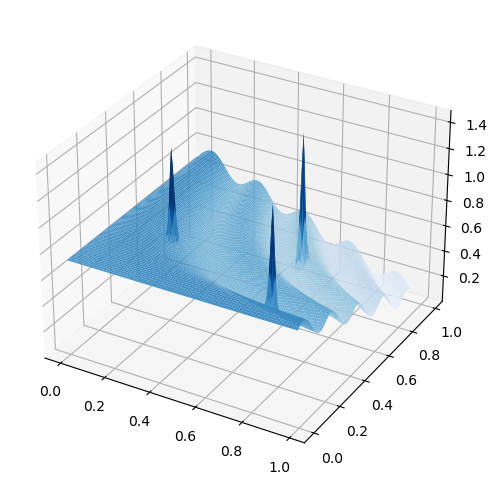

In [4]:
# visualize canonical problem
def mme_add_2d_plot(x1, x2):
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = mme_add_2d_plot(X1, X2)
from matplotlib import ticker, cm
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))

from matplotlib.colors import LightSource
ls = LightSource(270, 45)
rgb = ls.shade(Z.numpy(), cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)
# surf = ax.plot_surface(X1, X2, Z, facecolors=rgb, shade=False)
# plt.savefig(datasavedir + '/'+'2d_mean_behavior_surface'+'.png')

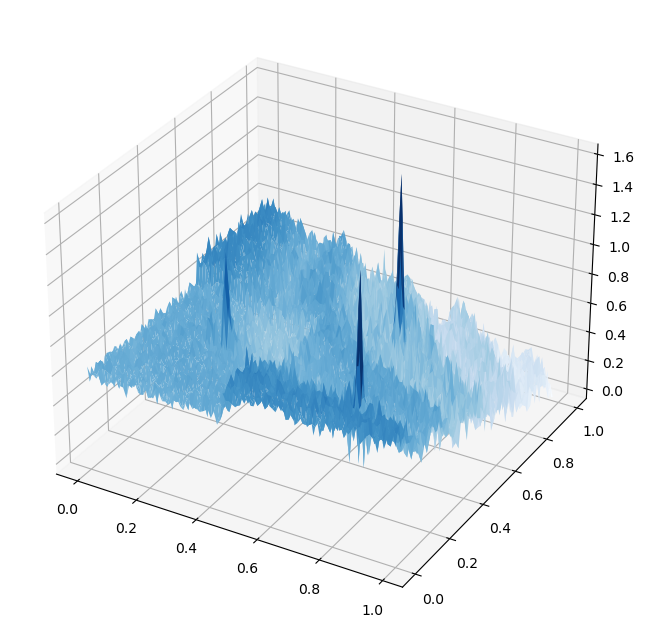

In [5]:
# visualizing with noise added
sigma_max = 0.12
sigma_min = 0.02
def noise_1_2d(x1, x2):
    # mean
    y = mme_add_2d_plot(x1, x2)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)
# plt.savefig(datasavedir + '/'+'2d_mme_noisyjump_surface'+'.png')

In [6]:
# formatting objective function to match the input format for botorch
sigma_max = 0.12
sigma_min = 0.02
def mme_add_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

def mme_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    # mean
    y = mme_add_2d(X)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    return mme_2d(x).type_as(x).unsqueeze(-1)

In [7]:
# set up the GP models for use
def initialize_model(train_x, train_obj, state_dict=None):
    """function to initialize the GP model"""
    model_obj = SingleTaskGP(train_x, train_obj)
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state_dict if it is not passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

# set up the initial data set
def generate_initial_data(n=10):
    """generate initial set of data to get started with BO loop"""
    train_x = torch.rand(10, 2, device=device, dtype=dtype)
    exact_obj = outcome_objective(train_x)
    train_obj = exact_obj
    best_observed_value = exact_obj.max().item()
    return train_x, train_obj, best_observed_value

# set up the acquisition function operations for botorch
BATCH_SIZE = 1  # only doing one parallel objective function evaluation
from botorch.optim import optimize_acqf
NUM_RESTARTS = 10
RAW_SAMPLES = 512
bounds = torch.tensor([[0.0, 1.0],[0.0, 1.0]], device=device, dtype=dtype)
def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,# initialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    new_obj = outcome_objective(new_x)
    return new_x, new_obj

def update_random_observation():
    """Simulates a random policy by taking the current list of best values observed
    randomly, drawing a new random point, observing its value, and updating the list
    """
    rand_x = torch.rand(BATCH_SIZE, 2)  # drawing from random uniform
    next_random_best = outcome_objective(rand_x)
    return  rand_x, next_random_best

In [8]:
# metrics functions
def count_number_peaks_observed_2d(x_obs, y_obs, num_known_peaks=3):
    """Function to count the number of peaks observed for the mme_noise_jump_1d function"""
    peak1, peak2, peak3 = False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.64 <= x[0] <= 0.66 and 0.64 <= x[1] <= 0.66:
            if y >= 1.37:
                peak1 = True
        elif 0.24 <= x[0] <= 0.26 and 0.34 <= x[1] <= 0.36:
            if y >= 1.06:
                peak2 = True
        elif 0.79 <= x[0] <= 0.81 and 0.14 <= x[1] <= 0.16:
            if y >= 1.36:
                peak3 = True
    num_peaks_observed = peak1 + peak2 + peak3
    return num_peaks_observed


def count_evaluations_for_all_peaks_2d(x_obs, y_obs):
    """Count the number of function evaluations before finding all peaks"""
    i = 0
    num_evals_for_all_peaks = x_obs.shape[0]
    peak1, peak2, peak3 = False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.64 <= x[0] <= 0.66 and 0.64 <= x[1] <= 0.66:
            if y >= 1.37:
                peak1 = True
        elif 0.24 <= x[0] <= 0.26 and 0.34 <= x[1] <= 0.36:
            if y >= 1.06:
                peak2 = True
        elif 0.79 <= x[0] <= 0.81 and 0.14 <= x[1] <= 0.16:
            if y >= 1.36:
                peak3 = True
        i += 1
        if peak1 and peak2 and peak3:
            num_evals_for_all_peaks = i
            break
    return num_evals_for_all_peaks

In [ ]:
# set up Bayesian optimization loop
from extremasearch.acquisition.nturbo import ngenerate_batch, NdTurboState, nd_new_update_state
from extremasearch.acquisition.qtead import nglobal_tead
import time
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from extremasearch.local.localsearch import initialize_scaled_model

N_TRIALS = 2
N_BATCH = 390 # note +10 for total iteration limit
MC_SAMPLES = 256
dim = 2
N_CANDIDATES = min(5000, max(2000, 200 * dim))
BATCH_SIZE = 1

verbose = True
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# set up arrays to hold arrays of data
# best values
best_observed_all_nei, best_observed_random_all, best_observed_all_tead = [], [], []
best_observed_all_turbo = []
# {x, y} values
x_observed_all_random, x_observed_all_nei, x_observed_all_tead = [], [], []
y_observed_all_random, y_observed_all_nei, y_observed_all_tead = [], [], []
x_observed_all_turbo = []
y_observed_all_turbo = []

# mmo results
distinct_peaks_random, distinct_peaks_nei, distinct_peaks_tead = [], [], []
function_evals_random, function_evals_nei, function_evals_tead = [], [], []
distinct_peaks_turbo = []
function_evals_turbo = []

# going to average over N_TRIALS
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    # set up arrays to hold data for this trial
    best_observed_nei, best_observed_random, best_observed_tead = [], [], []
    best_observed_turbo = []

    # generate initial training data and initial model for this trial
    # nei
    # use same initial training points
    train_x_nei, train_obj_nei, best_observed_value_nei = generate_initial_data(n=10)
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei)
    # tead
    # use same initial points
    train_x_tead, train_obj_tead = train_x_nei, train_obj_nei
    best_observed_value_tead = best_observed_value_nei
    mll_tead, model_tead = initialize_model(train_x_tead, train_obj_tead)
    # turbo
    train_x_turbo, train_obj_turbo = train_x_nei, train_obj_nei
    best_observed_value_turbo = best_observed_value_nei
    # turbo initialization
    state = NdTurboState(dim=2, batch_size=BATCH_SIZE, center=torch.tensor(0.5), lb=torch.tensor(0.0), ub=torch.tensor(1.0))
    state = nd_new_update_state(state, train_x_turbo, train_obj_turbo, torch.DoubleTensor([best_observed_value_turbo]))
    tr_x_turbo, tr_obj_turbo = state.get_training_samples_in_region()
    mll_turbo, model_turbo = initialize_scaled_model(tr_x_turbo, tr_obj_turbo)
    # random
    train_x_random, train_obj_random = train_x_nei, train_obj_nei
    best_observed_value_random = best_observed_value_nei

    # start collection of results from random initialization
    best_observed_nei.append(best_observed_value_nei)
    best_observed_random.append(best_observed_value_nei)
    best_observed_tead.append(best_observed_value_tead)
    best_observed_turbo.append(best_observed_value_turbo)
    best_observed_random.append(best_observed_value_random)

    # for N_BATCH rounds of BO after the initial random batch
    for iteration in range(1, N_BATCH + 1):
        t0 = time.monotonic()
        # fit models
        fit_gpytorch_mll(mll_nei)
        fit_gpytorch_mll(mll_tead)
        fit_gpytorch_mll(mll_turbo)

        # set up the sampler to use with the acq funcs
        qmc_sampler = SobolQMCNormalSampler(sample_shape=MC_SAMPLES)

        # set up the acquisition functions
        qNEI = qNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
        )

        # optimize the acquisition functions
        new_x_nei, new_obj_nei = optimize_acqf_and_get_observation(qNEI)
        new_x_tead = nglobal_tead(model_tead)
        new_obj_tead = outcome_objective(new_x_tead)
        new_x_turbo = ngenerate_batch(
            state=state,
            model=model_turbo,
            dim=state.train_x.shape[-1],
            x=state.train_x,
            y=state.train_y,
            batch_size=BATCH_SIZE,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf='ts',
        )
        new_obj_turbo = outcome_objective(new_x_turbo)
        # random
        new_x_random, new_obj_random = update_random_observation()

        # update training points
        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        train_x_tead = torch.cat([train_x_tead, new_x_tead])
        train_obj_tead = torch.cat([train_obj_tead, new_obj_tead])
        train_x_turbo = torch.cat([train_x_turbo, new_x_turbo])
        train_obj_turbo = torch.cat([train_obj_turbo, new_obj_turbo])
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])

        # update trust region
        state = nd_new_update_state(state, x_train=train_x_turbo, y_train=train_obj_turbo, y_next=new_obj_turbo)

        # update progress data
        best_value_random = train_obj_random.max()
        best_observed_random.append(best_value_random)
        best_value_nei = train_obj_nei.max()
        best_observed_nei.append(best_value_nei)
        best_value_tead = train_obj_tead.max()
        best_observed_tead.append(best_value_tead)
        best_value_turbo = train_obj_turbo.max()
        best_observed_turbo.append(best_value_turbo)

        # reinitialize the models so that they're ready to fit on the next iteration
        # state dict passed to speed up fitting
        mll_nei, model_nei = initialize_model(
            train_x_nei,
            train_obj_nei,
            model_nei.state_dict(),
        )
        mll_tead, model_tead = initialize_model(
            train_x_tead,
            train_obj_tead,
            model_tead.state_dict(),
        )
        # update trust region model
        tr_x_turbo, tr_obj_turbo = state.get_training_samples_in_region()
        mll_turbo, model_turbo = initialize_scaled_model(tr_x_turbo, tr_obj_turbo)

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qNEI, TEAD, TuRBO) = "
                f"({best_value_random:>4.2f}, {best_value_nei:>4.2f}, {best_value_tead:>4.2f}, {state.best_value:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    # collect observations from trial
    best_observed_all_nei.append(best_observed_nei)
    best_observed_random_all.append(best_observed_random)
    best_observed_all_tead.append(best_observed_tead)
    best_observed_all_turbo.append(best_observed_turbo)
    x_observed_all_random.append(train_x_random)
    x_observed_all_nei.append(train_x_nei)
    x_observed_all_tead.append(train_x_tead)
    x_observed_all_turbo.append(train_x_turbo)
    y_observed_all_random.append(train_obj_random)
    y_observed_all_nei.append(train_obj_nei)
    y_observed_all_tead.append(train_obj_tead)
    y_observed_all_turbo.append(train_obj_turbo)
    # collect metrics
    distinct_peaks_random.append(count_number_peaks_observed_2d(train_x_random, train_obj_random))
    distinct_peaks_nei.append(count_number_peaks_observed_2d(train_x_nei, train_obj_nei))
    distinct_peaks_tead.append(count_number_peaks_observed_2d(train_x_tead, train_obj_tead))
    distinct_peaks_turbo.append(count_number_peaks_observed_2d(train_x_turbo, train_obj_turbo))
    function_evals_random.append(count_evaluations_for_all_peaks_2d(train_x_random, train_obj_random))
    function_evals_nei.append(count_evaluations_for_all_peaks_2d(train_x_nei, train_obj_nei))
    function_evals_tead.append(count_evaluations_for_all_peaks_2d(train_x_tead, train_obj_tead))
    function_evals_turbo.append(count_evaluations_for_all_peaks_2d(train_x_turbo, train_obj_turbo))


Trial  1 of 2 

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch  1: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.73.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch  2: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.67.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch  3: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.61.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch  4: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.72.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch  5: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.50.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch  6: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.56.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch  7: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.62.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch  8: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.74.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch  9: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.84.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 10: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.66.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 11: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.77.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 12: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.70.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 13: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.81.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 14: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.67.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 15: best_value (random, qNEI, TEAD, TuRBO) = (0.82, 0.82, 0.82, 0.82), time = 6.69.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 16: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.82, 0.82, 0.82), time = 6.76.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 17: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.82, 0.82, 0.84), time = 6.60.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 18: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.82, 0.82, 0.84), time = 6.74.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 19: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.82, 0.82, 0.84), time = 6.67.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 20: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.82, 0.82, 0.84), time = 6.89.
TuRBO restart triggered

Batch 21: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.82, 0.82, 0.84), time = 6.65.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 22: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.82, 0.82, 0.84), time = 6.85.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 23: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.82, 0.82, 0.84), time = 6.66.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 24: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.82, 0.82, 0.84), time = 6.97.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 25: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 6.89.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 26: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 6.98.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 27: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.09.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 28: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 6.94.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 29: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 6.67.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 30: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 6.81.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 31: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.05.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 32: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 6.91.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 33: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.11.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 34: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 6.92.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 35: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.32.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 36: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.25.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 37: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.06.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 38: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 6.99.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 39: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.34.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 40: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.18.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 41: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.32.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 42: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.36.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 43: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.30.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 44: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.39.
TuRBO restart triggered

Batch 45: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.52.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 46: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.31.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 47: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.65.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 48: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.36.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 49: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.43.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 50: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.78.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 51: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.75.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 52: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.71.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 53: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.57.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 54: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.70.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 55: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.33.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 56: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.72.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 57: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.83.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 58: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.85, 0.82, 0.84), time = 7.93.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 59: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 7.48.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 60: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 7.74.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 61: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 7.50.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 62: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 7.98.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 63: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 7.76.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 64: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.14.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 65: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 7.81.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 66: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.06.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 67: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.00.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 68: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.08.
TuRBO restart triggered

Batch 69: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.12.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 70: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.14.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 71: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 7.73.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 72: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.21.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 73: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.09.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 74: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.34.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 75: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.27.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 76: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.46.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 77: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.27.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 78: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.28.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 79: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.54.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 80: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.47.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 81: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.84.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 82: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 9.58.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 83: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.41.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 84: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.70.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 85: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.59.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 86: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.85.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 87: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.59.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 88: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.76.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 89: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.65.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 90: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.95.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 91: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.97.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 92: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.84), time = 8.96.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 93: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.02.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 94: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 8.73.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 95: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.16.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 96: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 8.88.
TuRBO restart triggered

Batch 97: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.42.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 98: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.37.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 99: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.42.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 100: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.22.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 101: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.32.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 102: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 8.92.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 103: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.12.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 104: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.41.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 105: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.23.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 106: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.20.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 107: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.22.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 108: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.80.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 109: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.48.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 110: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.25.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 111: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.28.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 112: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.13.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 113: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.46.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 114: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.85.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 115: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.96.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 116: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.95.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 117: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.14.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 118: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.13.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 119: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.20.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 120: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.51.
TuRBO restart triggered

Batch 121: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.46.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 122: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.18.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 123: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.44.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 124: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.57.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 125: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.43.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 126: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.73.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 127: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.71.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 128: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.29.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 129: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 9.92.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 130: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.29.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 131: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.20.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 132: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.27.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 133: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.31.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 134: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.39.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 135: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.34.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 136: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.55.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 137: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.93.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 138: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.55.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 139: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 10.48.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 140: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.34.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 141: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.44.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 142: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.48.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 143: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.35.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 144: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.22.
TuRBO restart triggered

Batch 145: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.02.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 146: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.73.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 147: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.47.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 148: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 12.04.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 149: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.90.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 150: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 11.84.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 151: best_value (random, qNEI, TEAD, TuRBO) = (0.87, 0.89, 0.82, 0.86), time = 12.11.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 152: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.29.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 153: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 11.47.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 154: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.03.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 155: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.22.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 156: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 11.55.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 157: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 11.70.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 158: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.07.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 159: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 11.66.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 160: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.31.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 161: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.08.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 162: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.61.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 163: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.62.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 164: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.50.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 165: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.64.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 166: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.01.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 167: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.09.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 168: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.96.
TuRBO restart triggered

Batch 169: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.02.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 170: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.00.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 171: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.13.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 172: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.18.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 173: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.70.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 174: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.98.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 175: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.00.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 176: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.19.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 177: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.51.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 178: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.18.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 179: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.69.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 180: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.80.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 181: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.24.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 182: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.59.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 183: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.46.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 184: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.86.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 185: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.63.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 186: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.20.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 187: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 12.98.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 188: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.71.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 189: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.40.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 190: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.59.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 191: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.36.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 192: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.85.
TuRBO restart triggered

Batch 193: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 13.70.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 194: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.66.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 195: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.16.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 196: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.70.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 197: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.33.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 198: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.64.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 199: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.00.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 200: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.02.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 201: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.96.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 202: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.33.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 203: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 15.19.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 204: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.94.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 205: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.95.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 206: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.68.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 207: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 15.01.

/storage/home/hcoda1/5/abraafladt3/.conda/envs/mme/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)



Batch 208: best_value (random, qNEI, TEAD, TuRBO) = (0.93, 0.89, 0.82, 0.86), time = 14.97.

In [ ]:
# abbreviated QMC loop with Sobol sequences
from torch.quasirandom import SobolEngine

best_observed_all_sobol = []
x_observed_all_sobol, y_observed_all_sobol = [], []
distinct_peaks_sobol = []
function_evals_sobol = []
for trial in range(1, N_TRIALS + 1):
    print(f"\nSobol Trial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_sobol = []
    # get sobol random samples for the trial
    X_Sobol = SobolEngine(dimension=2, scramble=True).draw(N_BATCH+10).to(dtype=dtype, device=device)
    Y_Sobol = torch.tensor([outcome_objective(x) for x in X_Sobol], dtype=dtype, device=device)
    curMax = torch.max(Y_Sobol[:10])
    for y_val in Y_Sobol[10:]:
        curMax = torch.max(curMax,y_val)
        best_observed_sobol.append(curMax.squeeze())
    best_observed_all_sobol.append(best_observed_sobol)
    x_observed_all_sobol.append(X_Sobol)
    y_observed_all_sobol.append(Y_Sobol)
    distinct_peaks_sobol.append(count_number_peaks_observed_2d(X_Sobol, Y_Sobol))
    function_evals_sobol.append(count_evaluations_for_all_peaks_2d(X_Sobol, Y_Sobol))

In [ ]:
# collect output data
# calculate summary metrics
# peak ratio
num_known_peaks = 3
peak_ratio_random = sum(distinct_peaks_random) / (num_known_peaks * N_TRIALS)
peak_ratio_nei = sum(distinct_peaks_nei) / (num_known_peaks * N_TRIALS)
peak_ratio_tead = sum(distinct_peaks_tead) / (num_known_peaks * N_TRIALS)
peak_ratio_turbo = sum(distinct_peaks_turbo) / (num_known_peaks * N_TRIALS)
peak_ratio_sobol = sum(distinct_peaks_sobol) / (num_known_peaks * N_TRIALS)
print(f"Peak ratio: Random {peak_ratio_random:>4.2f}, NEI {peak_ratio_nei:>4.2f}, TEAD {peak_ratio_tead:>4.2f}, TuRBO {peak_ratio_turbo:>4.2f}, QMC {peak_ratio_sobol:>4.2f} ")
# success rate
num_successes_random = 0
num_successes_nei = 0
num_successes_tead = 0
num_successes_turbo = 0
num_successes_sobol = 0
for i in range(N_TRIALS):
    if distinct_peaks_random[i] == 3:
        num_successes_random += 1
    if distinct_peaks_nei[i] == 3:
        num_successes_nei += 1
    if distinct_peaks_tead[i] == 3:
        num_successes_tead += 1
    if distinct_peaks_turbo[i] == 3:
        num_successes_turbo += 1
    if distinct_peaks_sobol[i] == 3:
        num_successes_sobol += 1
success_ratio_random = num_successes_random / N_TRIALS
success_ratio_nei = num_successes_nei / N_TRIALS
success_ratio_tead = num_successes_tead / N_TRIALS
success_ratio_turbo = num_successes_turbo / N_TRIALS
success_ratio_sobol = num_successes_sobol / N_TRIALS
print(f"Success ratio: Random {success_ratio_random:>4.2f}, NEI {success_ratio_nei:>4.2f}, TEAD {success_ratio_tead:>4.2f}, TuRBO {success_ratio_turbo:>4.2f}, Sobol {success_ratio_sobol:>4.2f}")
# function evaluations
fe_random = sum(function_evals_random)/N_TRIALS
fe_nei = sum(function_evals_nei)/N_TRIALS
fe_tead = sum(function_evals_tead)/N_TRIALS
fe_turbo = sum(function_evals_turbo)/N_TRIALS
fe_sobol = sum(function_evals_sobol)/N_TRIALS
print(f"Average function evaluations: Random {fe_random}, NEI {fe_nei}, TEAD {fe_tead}, TuRBO {fe_turbo}, Sobol {fe_sobol}")

In [ ]:
# save data to file for potential future use
methods_list = ['MCS', 'NEI', 'TEAD', 'TuRBO', 'QMC']
pr_list = [peak_ratio_random, peak_ratio_nei, peak_ratio_tead, peak_ratio_turbo, peak_ratio_sobol]
peak_list = [distinct_peaks_random, distinct_peaks_nei, distinct_peaks_tead, distinct_peaks_turbo, distinct_peaks_sobol]
success_list = [num_successes_random, num_successes_nei, num_successes_tead, num_successes_turbo, num_successes_sobol]
num_reps = N_TRIALS
sr_list = [success_ratio_random, success_ratio_nei, success_ratio_tead, success_ratio_turbo, success_ratio_sobol]
fe_list = [function_evals_random, function_evals_nei, function_evals_tead, function_evals_turbo, function_evals_sobol]

torch.save([methods_list, pr_list, peak_list, success_list, num_reps, sr_list, fe_list], '2d_bench_mme_metrics_v2'+strtime+'.pt')


In [ ]:
fit_gpytorch_mll(mll_nei)
fit_gpytorch_mll(mll_tead)
fit_gpytorch_mll(mll_turbo)
None

In [ ]:
# plot evaluations for tead - surface
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0, alpha=0.2)
ax.scatter(train_x_tead[:,0].numpy()[0:10], train_x_tead[:,1].numpy()[0:10], train_obj_tead.numpy()[0:10], marker='.', color='tab:orange', s=40)
ax.scatter(train_x_tead[:,0].numpy()[10:], train_x_tead[:,1].numpy()[10:], train_obj_tead.numpy()[10:], marker='.', color='g', s=40)
# plt.savefig(datasavedir + '/'+'2d_mme_noise_tead_evals'+'.png')
plt.savefig(strtime+'2d_mme_noise_tead_evals'+'.png')

In [ ]:
# plot evaluations for tead contour
fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
cbar = fig1.colorbar(CS)

ax1.scatter(train_x_tead[:,0].numpy()[0:10], train_x_tead[:,1].numpy()[0:10], s=15, marker='o', color='tab:orange', zorder=2)
ax1.scatter(train_x_tead[:,0].numpy()[10:], train_x_tead[:,1].numpy()[10:], s=15, marker='o', color='g', zorder=2)
ax1.set_xlim([-0.01,1.01])
ax1.set_ylim([-0.01,1.01])
# plt.savefig(datasavedir + '/'+'2d_mme_noise_tead_evals_contour'+'.png')
plt.savefig(strtime+'2d_mme_noise_tead_evals_contour'+'.png')

In [ ]:
# plot model contours tead - mean
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z_tead_model = model_tead.posterior(torch.stack([X1.flatten(), X2.flatten()], dim=1)).mean
Z_tead_shaped = Z_tead_model.unflatten(dim=0, sizes=(100,100)).squeeze()

fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z_tead_shaped.detach().numpy(), levels=15, cmap='viridis')
cbar = fig1.colorbar(CS)
# plt.savefig(datasavedir + '/'+'2d_mme_noise_tead_model_mean_contour'+'.png')
plt.savefig(strtime+'2d_mme_noise_tead_model_mean_contour'+'.png')

In [ ]:
# plot model contours tead - standard deviation
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z_tead_model = model_tead.posterior(torch.stack([X1.flatten(), X2.flatten()], dim=1)).variance
Z_tead_shaped = Z_tead_model.unflatten(dim=0, sizes=(100,100)).squeeze()

fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, np.sqrt(Z_tead_shaped.detach().numpy()), levels=15, cmap='viridis')
cbar = fig1.colorbar(CS)
# plt.savefig(datasavedir + '/'+'2d_mme_noise_tead_model_stdev_contour'+'.png')
plt.savefig(strtime+'2d_mme_noise_tead_model_stdev_contour'+'.png')

In [ ]:
# plot evaluations for nei
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0, alpha=0.2)
ax.scatter(train_x_nei[:,0].numpy(), train_x_nei[:,1].numpy(), train_obj_nei.numpy(), marker='.', color='g')
# plt.savefig(datasavedir + '/'+'2d_mme_noise_nei_evals_surface'+'.png')
plt.savefig(strtime+'2d_mme_noise_nei_evals_surface'+'.png')

In [ ]:
# plot evaluations for nei contour
fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
cbar = fig1.colorbar(CS)
ax1.scatter(train_x_nei[:,0].numpy()[0:10], train_x_nei[:,1].numpy()[0:10], s=15, marker='o', color='tab:orange', zorder=2)
ax1.scatter(train_x_nei[:,0].numpy()[10:], train_x_nei[:,1].numpy()[10:], s=15, marker='o', color='g', zorder=2)
ax1.set_xlim([-0.01,1.01])
ax1.set_ylim([-0.01,1.01])
# plt.savefig(datasavedir + '/'+'2d_mme_noise_nei_evals_contour'+'.png')
plt.savefig(strtime+'2d_mme_noise_nei_evals_contour'+'.png')

In [ ]:
# plot model contours nei - mean
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z_nei_model = model_nei.posterior(torch.stack([X1.flatten(), X2.flatten()], dim=1)).mean
Z_nei_shaped = Z_nei_model.unflatten(dim=0, sizes=(100,100)).squeeze()

fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z_nei_shaped.detach().numpy(), levels=15, cmap='viridis')
cbar = fig1.colorbar(CS)
plt.savefig(strtime+'2d_mme_noise_nei_model_mean_contour'+'.png')
# plt.savefig(datasavedir + '/'+'2d_mme_noise_nei_model_mean_contour'+'.png')

In [ ]:
# plot model contours nei - stdev
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z_nei_model = model_nei.posterior(torch.stack([X1.flatten(), X2.flatten()], dim=1)).variance
Z_nei_shaped = Z_nei_model.unflatten(dim=0, sizes=(100,100)).squeeze()

fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, np.sqrt(Z_nei_shaped.detach().numpy()), levels=15, cmap='viridis')
cbar = fig1.colorbar(CS)
# plt.savefig(datasavedir + '/'+'2d_mme_noise_nei_model_stdev_contour'+'.png')
plt.savefig(strtime+'2d_mme_noise_nei_model_stdev_contour'+'.png')

In [ ]:
# plot evaluations for turbo - surface
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0, alpha=0.2)
ax.scatter(train_x_turbo[:,0].numpy()[0:10], train_x_turbo[:,1].numpy()[0:10], train_obj_turbo.numpy()[0:10], marker='.', color='tab:orange', s=40)
ax.scatter(train_x_turbo[:,0].numpy()[10:], train_x_turbo[:,1].numpy()[10:], train_obj_turbo.numpy()[10:], marker='.', color='g', s=40)
# plt.savefig(datasavedir + '/'+'2d_mme_noise_turbo_evals_surface'+'.png')
plt.savefig(strtime+'2d_mme_noise_turbo_evals_surface'+'.png')

In [ ]:
# plot evaluations for tead contour
fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
cbar = fig1.colorbar(CS)

ax1.scatter(train_x_turbo[:,0].numpy()[0:10], train_x_turbo[:,1].numpy()[0:10], s=15, marker='o', color='tab:orange', zorder=2)
ax1.scatter(train_x_turbo[:,0].numpy()[10:], train_x_turbo[:,1].numpy()[10:], s=15, marker='o', color='g', zorder=2)
ax1.set_xlim([-0.01,1.01])
ax1.set_ylim([-0.01,1.01])
# plt.savefig(datasavedir + '/'+'2d_mme_noise_turbo_evals_contour'+'.png')
plt.savefig(strtime+'2d_mme_noise_turbo_evals_contour'+'.png')

In [ ]:
# plot model contours turbo - mean
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z_tead_model = model_turbo.posterior(torch.stack([X1.flatten(), X2.flatten()], dim=1)).mean
Z_tead_shaped = Z_tead_model.unflatten(dim=0, sizes=(100,100)).squeeze()

fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z_tead_shaped.detach().numpy(), levels=15, cmap='viridis')
cbar = fig1.colorbar(CS)
# plt.savefig(datasavedir + '/'+'2d_mme_noise_turbo_model_mean_contour'+'.png')
plt.savefig(strtime+'2d_mme_noise_turbo_model_mean_contour'+'.png')

In [ ]:
# plot model contours turbo - standard deviation
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z_tead_model = model_turbo.posterior(torch.stack([X1.flatten(), X2.flatten()], dim=1)).variance
Z_tead_shaped = Z_tead_model.unflatten(dim=0, sizes=(100,100)).squeeze()

fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, np.sqrt(Z_tead_shaped.detach().numpy()), levels=15, cmap='viridis')
cbar = fig1.colorbar(CS)
plt.savefig(strtime+'2d_mme_noise_turbo_model_stdev_contour'+'.png')

In [ ]:
# plot evaluations for sobol - surface
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0, alpha=0.2)
ax.scatter(X_Sobol[:,0].numpy(), X_Sobol[:,1].numpy(), Y_Sobol.numpy(), marker='.', color='g', s=40)
plt.savefig(strtime+'2d_mme_noise_qmc_sobol_evals_surface'+'.png')

In [ ]:
# plot evaluations for sobol contour
fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
cbar = fig1.colorbar(CS)

ax1.scatter(X_Sobol[:,0].numpy(), X_Sobol[:,1].numpy(), s=15, marker='o', color='g', zorder=2)
ax1.set_xlim([-0.01,1.01])
ax1.set_ylim([-0.01,1.01])
plt.savefig(strtime+'2d_mme_noise_qmc_evals_contour'+'.png')

In [ ]:
# plot evaluations for mcs - surface
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0, alpha=0.2)
ax.scatter(train_x_random[:,0].numpy(), train_x_random[:,1].numpy(), train_obj_random.numpy(), marker='.', color='g', s=40)
plt.savefig(strtime+'2d_mme_noise_mcs_evals_surface'+'.png')

In [ ]:
# plot evaluations for mcs contour
fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
cbar = fig1.colorbar(CS)
ax1.scatter(train_x_random[:,0].numpy(), train_x_random[:,1].numpy(), s=15, marker='o', color='g', zorder=2)
ax1.set_xlim([-0.01,1.01])
ax1.set_ylim([-0.01,1.01])
plt.savefig(strtime+'2d_mme_noise_mcs_evals_contour'+'.png')

In [ ]:
# # save data to file for potential future use
# methods_list = ['MCS', 'NEI', 'TEAD', 'TuRBO', 'QMC']
# pr_list = [peak_ratio_random, peak_ratio_nei, peak_ratio_tead, peak_ratio_turbo, peak_ratio_sobol]
# sr_list = [success_ratio_random, success_ratio_nei, success_ratio_tead, success_ratio_turbo, success_ratio_sobol]
# fe_list = [function_evals_random, function_evals_nei, function_evals_tead, function_evals_turbo, function_evals_sobol]
# import pickle
# with open(strtime + 'mme_metrics_benchmark.pkl', 'wb') as f:
#     pickle.dump([methods_list, pr_list, sr_list, fe_list], f)
# # to retrieve
# # with open(datasavedir + '/' + 'mme_metrics.pkl') as f:
# #     methods_list, pr_list, sr_list, fe_list = pickle.load(f)